<a href="https://colab.research.google.com/github/rickygrosvenor-pramanick/learn-ml/blob/main/pytorch/nn_workflow_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Create Dataset
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
                    noise=0.7,
                    factor=0.8,
                    random_state=42)

In [3]:
# Convert to Tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [4]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Agnostic Code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Investigate Data Format
# X gives 2 numbers as input, y returns 1 number as output
X_train[:5], y_train[:5]

(tensor([[ 1.3037,  0.1872],
         [-0.3370, -0.6710],
         [-1.4545,  0.4610],
         [-0.7890, -0.2558],
         [-0.0992,  1.1932]]),
 tensor([1., 0., 0., 0., 1.]))

In [7]:
# Create Model Class
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=3)
    self.layer_3 = nn.Linear(in_features=3, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [8]:
# Create Model Instance
model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=3, bias=True)
  (layer_3): Linear(in_features=3, out_features=1, bias=True)
)

In [9]:
# Initial Predictions without Training
import math
with torch.inference_mode():
  untrained_preds = model1(X_test.to(device))
untrained_preds[:5], y_test[:5]

(tensor([[-0.0597],
         [-0.1511],
         [-0.0253],
         [-0.1848],
         [ 0.1243]]),
 tensor([1., 0., 1., 0., 1.]))

In [12]:
# Create a loss function

# For Regression, you may want MSE or MAE
# For Classification, Binary Cross Entropy or Categorical Cross Entropy
loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to input

# loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built in
# This is somewhat similar to
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
# nn.BCEWithLogitsLoss() is more numerically stable than plain nn.Sigmoid->nn.BCELoss but we'll do it the other way
# to get a sense of the work better

optimiser = torch.optim.SGD(params=model1.parameters(), lr=0.1)


In [13]:
# parameters getting updated by SGD
model1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.7015,  0.2477],
                      [-0.5769,  0.2338],
                      [-0.0068, -0.4723],
                      [ 0.6968,  0.6700],
                      [ 0.5463, -0.0156],
                      [ 0.2063,  0.5656],
                      [-0.6739,  0.4205],
                      [ 0.2840, -0.3270]])),
             ('layer_1.bias',
              tensor([-0.6278, -0.0966,  0.6565, -0.3960, -0.6639, -0.2961, -0.4961, -0.3444])),
             ('layer_2.weight',
              tensor([[ 0.0267, -0.1080, -0.0367, -0.3084, -0.0355, -0.1487,  0.0841,  0.0495],
                      [ 0.3295, -0.1881, -0.1290,  0.1139,  0.2046,  0.1752, -0.0825, -0.1018],
                      [ 0.0041,  0.3091, -0.0850,  0.2778,  0.0381, -0.0170, -0.2706,  0.0139]])),
             ('layer_2.bias', tensor([ 0.2209, -0.2496,  0.1584])),
             ('layer_3.weight', tensor([[ 0.1097,  0.0277, -0.2358]])),
             ('layer_3.bias', tensor([-

In [14]:
tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([1, 9, 3])
torch.eq(tensor1, tensor2).sum(), torch.eq(tensor1, tensor2).sum().item(), torch.eq(tensor1, tensor2)

(tensor(2), 2, tensor([ True, False,  True]))

In [15]:
# Create an Accuracy Function - https://www.youtube.com/watch?v=RYFViaaJxE8&ab_channel=MathsResource as a Percentage
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct/len(y_pred)) * 100
  return accuracy

In [16]:
# Train Model

# Logits are the raw outputs of our models - output from the forward() function of our model class.
# We want to go from logits -> prediction probabilities -> prediction label

# We can convert Logits into Prediction Probabilities by passing them through an activation function
# Generally sigmoid for binary classification and softmax for multiclass classification

# Logits from Model Output
y_logits = model1(X_test.to(device))

# Pass through Sigmoid Function to get Prediction Probabilities
y_pred_probs = torch.sigmoid(y_logits)

# Round the Prediction Probabilities to get Classification Category or Prediction Label.
y_preds = torch.round(y_pred_probs)
y_preds[:5], y_test[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.]))

In [17]:
# As seen from above, y_preds has an extra redundant dimension
y_preds.size()

torch.Size([200, 1])

In [18]:
# So we squeeze the Tensor
y_preds.squeeze()[:5], y_test[:5]

(tensor([0., 0., 0., 0., 1.], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.]))

In [19]:
# Building a Training and Testing Loop
torch.manual_seed(42)

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model1.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
  loss = loss_fn(torch.sigmoid(y_logits), y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # 3. Optimizer zero grad
  optimiser.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimiser.step()

  ### Testing
  model1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(torch.sigmoid(test_logits), y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")



Epoch: 0 | Loss: 0.69430, Accuracy: 49.50% | Test loss: 0.69251, Test acc: 54.00%
Epoch: 10 | Loss: 0.69413, Accuracy: 49.75% | Test loss: 0.69248, Test acc: 53.50%
Epoch: 20 | Loss: 0.69399, Accuracy: 49.25% | Test loss: 0.69247, Test acc: 53.00%
Epoch: 30 | Loss: 0.69387, Accuracy: 49.38% | Test loss: 0.69248, Test acc: 53.00%
Epoch: 40 | Loss: 0.69377, Accuracy: 49.12% | Test loss: 0.69250, Test acc: 53.50%
Epoch: 50 | Loss: 0.69368, Accuracy: 49.50% | Test loss: 0.69252, Test acc: 54.00%
Epoch: 60 | Loss: 0.69360, Accuracy: 49.50% | Test loss: 0.69255, Test acc: 54.00%
Epoch: 70 | Loss: 0.69354, Accuracy: 49.38% | Test loss: 0.69258, Test acc: 54.00%
Epoch: 80 | Loss: 0.69348, Accuracy: 49.50% | Test loss: 0.69261, Test acc: 54.00%
Epoch: 90 | Loss: 0.69343, Accuracy: 49.38% | Test loss: 0.69264, Test acc: 54.00%
Epoch: 100 | Loss: 0.69338, Accuracy: 48.75% | Test loss: 0.69268, Test acc: 53.50%
Epoch: 110 | Loss: 0.69334, Accuracy: 48.50% | Test loss: 0.69271, Test acc: 54.00%
Epo

In [20]:
# Improving Our Model

# Add More Layers
# Add More Hidden Units
# Fit for Longer with More Epochs
# Change/Add Activation Functions
# Change the Learning Rate
# Change the Loss Function
# Use Transfer Learning

# Making a new and larger model
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=64)
    self.layer_4 = nn.Linear(in_features=64, out_features=256)
    self.layer_5 = nn.Linear(in_features=256, out_features=1)

  def forward(self, x):
    return self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))

In [27]:
# Create an instance of our model
model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=1, bias=True)
)

In [22]:
# Set up loss and optimiser functions
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimiser = torch.optim.SGD(model2.parameters(), lr=0.1)

In [23]:
# Training and Testing
torch.manual_seed(42)

epochs = 1000

# Put data into device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model2.train()

  y_logits = model2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  model2.eval()
  with torch.inference_mode():
    test_logits = model2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.69375, Accuracy: 49.00% | Test loss: 0.69320, Test acc: 48.00%
Epoch: 10 | Loss: 0.69318, Accuracy: 50.75% | Test loss: 0.69339, Test acc: 48.00%
Epoch: 20 | Loss: 0.69305, Accuracy: 51.00% | Test loss: 0.69355, Test acc: 48.00%
Epoch: 30 | Loss: 0.69298, Accuracy: 51.75% | Test loss: 0.69369, Test acc: 48.00%
Epoch: 40 | Loss: 0.69294, Accuracy: 52.62% | Test loss: 0.69381, Test acc: 48.00%
Epoch: 50 | Loss: 0.69292, Accuracy: 52.00% | Test loss: 0.69391, Test acc: 48.00%
Epoch: 60 | Loss: 0.69291, Accuracy: 51.75% | Test loss: 0.69399, Test acc: 48.00%
Epoch: 70 | Loss: 0.69291, Accuracy: 52.00% | Test loss: 0.69405, Test acc: 48.00%
Epoch: 80 | Loss: 0.69291, Accuracy: 52.25% | Test loss: 0.69410, Test acc: 48.00%
Epoch: 90 | Loss: 0.69290, Accuracy: 52.00% | Test loss: 0.69414, Test acc: 48.00%
Epoch: 100 | Loss: 0.69290, Accuracy: 52.38% | Test loss: 0.69417, Test acc: 48.00%
Epoch: 110 | Loss: 0.69290, Accuracy: 52.12% | Test loss: 0.69419, Test acc: 48.00%
Epo

In [41]:
# Checking if our model can model a straight line

# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [48]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


In [55]:
# Making a Neural Network Model (based on ModelV2) fit a Linear Model
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=1, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=64)
    self.layer_4 = nn.Linear(in_features=64, out_features=256)
    self.layer_5 = nn.Linear(in_features=256, out_features=1)

  def forward(self, x):
    return self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))

# Create an instance of our model
model2 = CircleModelV3().to(device)
model2

CircleModelV3(
  (layer_1): Linear(in_features=1, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=1, bias=True)
)

In [56]:
# Set up Loss and Optimiser Functions
loss_fn = nn.L1Loss() # MAE as this is recommended for regression problems
optimiser = torch.optim.SGD(model2.parameters(), lr=0.1)

In [59]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model2.train()

  ### Training
  # 1. Forward pass
  y_pred = model2(X_train_regression)

  # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimizer zero grad
  optimiser.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimiser.step()

  model2.eval()
  with torch.inference_mode():
    # 1. Forward pass
      test_pred = model2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.13953, Test loss: 0.29333
Epoch: 100 | Train loss: 0.12165, Test loss: 0.07677
Epoch: 200 | Train loss: 0.02563, Test loss: 0.17205
Epoch: 300 | Train loss: 0.12919, Test loss: 0.04517
Epoch: 400 | Train loss: 0.07161, Test loss: 0.13711
Epoch: 500 | Train loss: 0.03098, Test loss: 0.02992
Epoch: 600 | Train loss: 0.06223, Test loss: 0.17359
Epoch: 700 | Train loss: 0.04451, Test loss: 0.13583
Epoch: 800 | Train loss: 0.12093, Test loss: 0.05852
Epoch: 900 | Train loss: 0.04118, Test loss: 0.11695


helper_functions.py already exists, skipping download


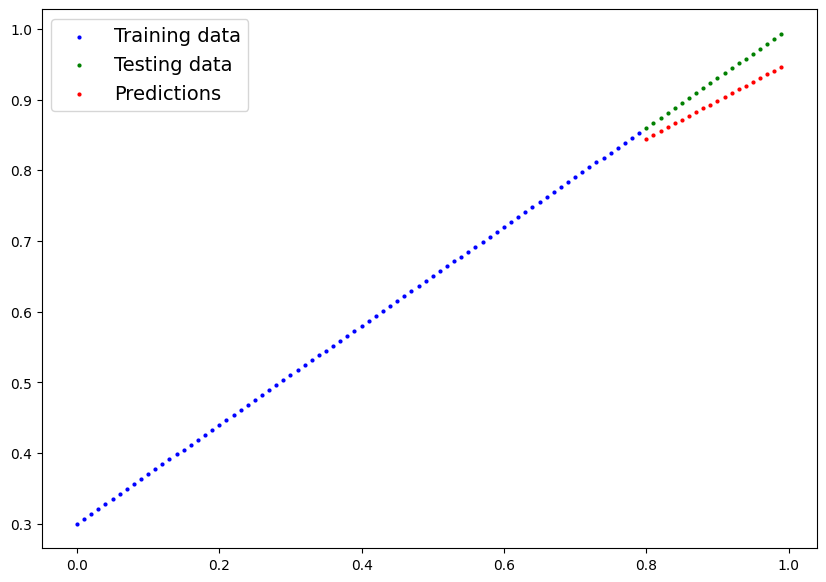

In [60]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Turn on evaluation mode
model2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());


In [61]:
## Alright, it looks like our model is able to do far better than random guessing on straight lines.